## Sandox for Developing Resnet
Notes, ideas, and general approach to building Resnet from the ground up.

## General Approach

fastai for data handling and training, pytorch for architecure. 

1. Use fast.ai for downloading data / preprocessing / loading / augmentations etc.
- Unroll and practice NN building and training loops
- Create a basic neural network to run through MNIST using pytorch
- Create a better neural network with multiple layers and convolutions in pytorch
- Download CIFAR
- Create VGG
- Create ResNet
- Create wide ResNet
- figure out how to use performance improvements from fastai pillo
- Download COCO
- Try training only on COCO
- Try training on CIFAR, then COCO
- Try making final Detectron Wide Resnet using  
- pretrain on imagenet, then COCO 
- Clean up and put into module for use as backbone retinanet
- Do a short write up of experience

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from dataclasses import dataclass

## MNIST

In [42]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

[PosixPath('/home/sudosharma/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/home/sudosharma/.fastai/data/mnist_sample/models'),
 PosixPath('/home/sudosharma/.fastai/data/mnist_sample/train'),
 PosixPath('/home/sudosharma/.fastai/data/mnist_sample/valid')]

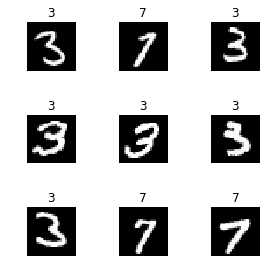

In [43]:
data = ImageDataBunch.from_folder(path)
data.show_batch(rows=3, figsize=(4, 4))

## NN v1

In [6]:
model = simple_cnn((3, 16, 16, 2))
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.133678,0.106639,0.964181,00:01


## NN v2

In [7]:
model = models.resnet50
learn = create_cnn(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.146359,0.093797,0.969087,00:06


## NN v3

In [7]:
@dataclass
class PrintOutput(LearnerCallback):
    """Function to figure out if fastai is modifying final tensor before loss_func."""
    learn: Learner

    def on_loss_begin(self, **kwargs):
        if kwargs['num_batch'] == 1: print(kwargs['last_output'].shape)
        return kwargs['last_output']

    
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [8]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(3*28*28, 50), nn.ReLU(True),
    nn.Linear(50, 50)
)
learn = Learner(data, model, metrics=accuracy)
cb = PrintOutput(learn)
learn.fit(1, callbacks=[cb])

epoch,train_loss,valid_loss,accuracy,time
1,0.056079,0.093036,0.973503,00:01


torch.Size([64, 50])


## NN v4

In [9]:
model = nn.Sequential(
    nn.Conv2d(3, 256, 3, 1), nn.ReLU(True),
    nn.Conv2d(256, 128, 3, 1), nn.ReLU(True),
    nn.Conv2d(128, 64, 3, 1), nn.ReLU(True),
    nn.AdaptiveMaxPool2d(1),
    Flatten())
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.122984,0.076745,0.974485,00:02


## NN v5

In [13]:
??nn.Conv2d

In [14]:
def conv(ic, oc, k=3, s=1, actn=False):
    """A conv layer module."""
    layers = [nn.Conv2d(ic, oc, k, stride=s, padding=k//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)


class SimpleCNN(nn.Module):
    """A convnet block using module list approach."""
    def __init__(self, *cs):
        super().__init__()
        self.layers = nn.ModuleList(
            [conv(cs[i], cs[i+1], actn=True) for i in range(len(cs)-1)])
        self.layers.extend([nn.AdaptiveMaxPool2d(1), Flatten()])
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [11]:
model = SimpleCNN(3, 256, 128, 64)
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.102602,0.102861,0.963690,00:02



## CIFAR-10

In [44]:
path = untar_data(URLs.CIFAR)
path.ls()

[PosixPath('/home/sudosharma/.fastai/data/cifar10/models'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/test'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/labels.txt'),
 PosixPath('/home/sudosharma/.fastai/data/cifar10/train')]

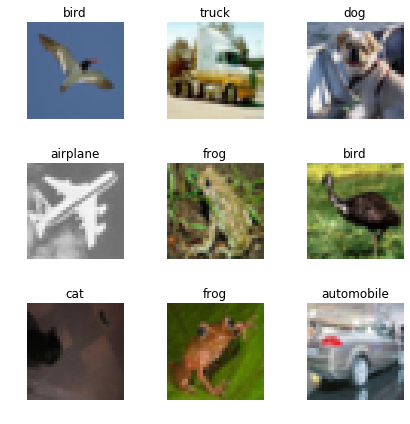

In [45]:
tfms = get_transforms(
    max_rotate=None, 
    max_zoom=1.0,  
    max_warp=None, 
    p_affine=0, 
    xtra_tfms=[rand_crop()])

data = (ImageList.from_folder(path)
        .split_by_folder(valid='test')
        .label_from_folder()
        .transform(tfms)
        .databunch(bs=256)
        .normalize(cifar_stats))

data.show_batch(3, figsize=(6, 6))

## NN v6 (VGG19)

In [5]:
class ConvBlock(nn.Module):
    """A conv block with pooling and 'n' convs."""
    def __init__(self, ic, oc, l, actn=True, pool=None):
        super().__init__()
        self.layers = nn.ModuleList([conv(ic, oc, actn=actn)])
        self.layers.extend(conv(oc, oc, actn=actn) for _ in range(l-1))
        if pool == 'max':
            self.layers.append(nn.MaxPool2d(2, stride=2))
        elif pool == 'avg':
            self.layers.append(nn.AvgPool2d(2, stride=2))
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x
                           
        
class VGG_19(nn.Module):
    """A VGG implementation."""
    def __init__(self, actn=True, pool='max'):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 64, 2, actn=actn, pool=pool),
            ConvBlock(64, 128, 2, actn=actn, pool=pool),
            ConvBlock(128, 256, 4, actn=actn, pool=pool),
            ConvBlock(256, 512, 4, actn=actn, pool=pool),
            ConvBlock(512, 512, 4, actn=actn, pool=pool),
            Flatten(),
            nn.Linear(512, 4096),
            nn.Dropout(0.5, inplace=True),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.Dropout(0.5, inplace=True),
            nn.ReLU(True),
            nn.Linear(4096, 10))
    
    def forward(self, x):
        return self.layers(x)
    

def fit_lrs(learn, lr_epochs, wd=None, save='improvement'):
    """Fits learner with training phases, and saving functionality."""
    phases = [TrainingPhase(len(data.train_dl)*e, lr, moms=0.9) for e, lr in lr_epochs]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    total_epochs = sum(e for e, _ in lr_epochs)
    learn.fit(
        total_epochs, 
        wd=wd, 
        callbacks=[SaveModelCallback(learn, every=save, monitor='accuracy', name='vgg19')])
    return learn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


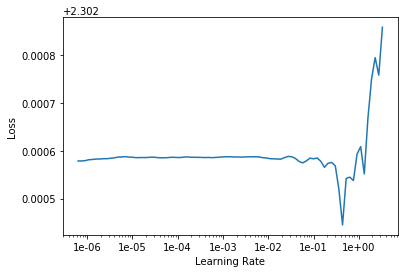

In [64]:
model = VGG_19()
learn = Learner(data, model, metrics=accuracy, opt_func=torch.optim.SGD, loss_func=F.cross_entropy)
learn.init(nn.init.xavier_uniform_)
learn.lr_find()
learn.recorder.plot()

In [65]:
lr_epochs = [(5, 1e-4),(30, 1e-2), (25, 1e-3), (15, 1e-4)]
learn = fit_lrs(learn, lr_epochs, wd=5e-4)

epoch,train_loss,valid_loss,accuracy,time
1,2.302583,2.302568,0.128900,00:10
2,2.302564,2.302546,0.125600,00:10
3,2.302545,2.302526,0.117300,00:10
4,2.302526,2.302509,0.109800,00:10
5,2.302511,2.302496,0.126500,00:10
6,2.302836,2.302704,0.100000,00:10
7,2.302740,2.302520,0.100000,00:10
8,2.302511,2.302220,0.100000,00:10
9,2.300013,2.296085,0.149400,00:10
10,2.095595,1.972867,0.211000,00:11


Better model found at epoch 1 with accuracy value: 0.12890000641345978.
Better model found at epoch 9 with accuracy value: 0.149399995803833.
Better model found at epoch 10 with accuracy value: 0.210999995470047.
Better model found at epoch 11 with accuracy value: 0.23190000653266907.
Better model found at epoch 12 with accuracy value: 0.2799000144004822.
Better model found at epoch 13 with accuracy value: 0.3183000087738037.
Better model found at epoch 14 with accuracy value: 0.37560001015663147.
Better model found at epoch 15 with accuracy value: 0.427700012922287.
Better model found at epoch 16 with accuracy value: 0.46070000529289246.
Better model found at epoch 17 with accuracy value: 0.49900001287460327.
Better model found at epoch 18 with accuracy value: 0.5827000141143799.
Better model found at epoch 19 with accuracy value: 0.6371999979019165.
Better model found at epoch 20 with accuracy value: 0.6743000149726868.
Better model found at epoch 21 with accuracy value: 0.6872000098

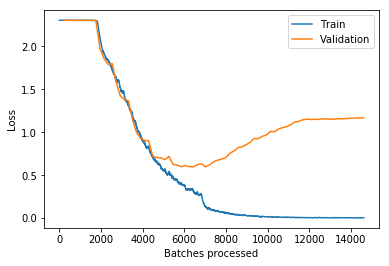

In [66]:
learn.recorder.plot_losses()

### VGG Analysis

In [9]:
pd.DataFrame({'VGG Paper top-1 val. error (%)': [25.5], 'Implementation top-1 val. error (%)': [1-.842]})

,VGG Paper top-1 val. error (%),Implementation top-1 val. error (%)
0,25.5,0.158


I only used the original optimizer, momentum, lr schedule, weight decay, architecture, initializations, and so on, from the original paper in 2015, so then:

<b>Why did this do so much better?</b>
- better hardware optimizations built-in with Nvidia
- fastai very opinionated, probably has optimizations I haven't discovered yet
- Most importantly, CIFAR-10 a much easier dataset than ImageNet and has smaller images

<b>Why did it not perform even better?</b>
- CIFAR-10 dataset pretty small
- hyperparameters tuned for ImageNet not CIFAR-10
- CIFAR-10 images are much lower quality
- batch size too high
- no RGB color shift (PCA color augmentation)
- no scale jittering
- obvious, but could have used all modern improvements (batch norm, adamw, 1cycle, etc.)

## NN v7

In [15]:
??conv

In [ ]:
def ResBlock(nn.Module):
    def __init__(self, ic, oc, l):
        super().__init__()
        conv(ic, oc)
        
        
    def forward(x):
        return self.layers(x)